# Quality Control

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
from scipy.stats import median_abs_deviation
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import os
os.chdir("/data/home/wx/") 
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)


ModuleNotFoundError: No module named 'anndata2ri'

In [7]:
%%R
inputdir<-c('scislets/data/CT/output/')
outputdir<-c('scislets/data/CT/output/h5ad')
library(Seurat)
library(MuDataSeurat)
data <- Read10X(data.dir = paste0(inputdir,'/','filter_matrix'), gene.colum=1)
data <- CreateSeuratObject(counts = data, min.cells = 0, min.features = 0, project = "CT")
MuDataSeurat::WriteH5AD(data, paste0(outputdir,'/','filter.h5ad'), assay="RNA")
data.raw<-Read10X(data.dir = paste0(inputdir,'/','raw_matrix'), gene.colum=1)
data.raw <- CreateSeuratObject(counts = data.raw, min.cells = 0, min.features = 0, project = "CT")
MuDataSeurat::WriteH5AD(data.raw, paste0(outputdir,'/','raw.h5ad'), assay="RNA")

In [41]:
adata = sc.read_h5ad(
    filename='/data/home/wx/scislets/data/CT/output/h5ad/filter.h5ad'
)
adata

AnnData object with n_obs × n_vars = 6489 × 34413
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    layers: 'counts'

In [42]:
adata.var_names_make_unique()

In [43]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [44]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [45]:
#Basic filtering: 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

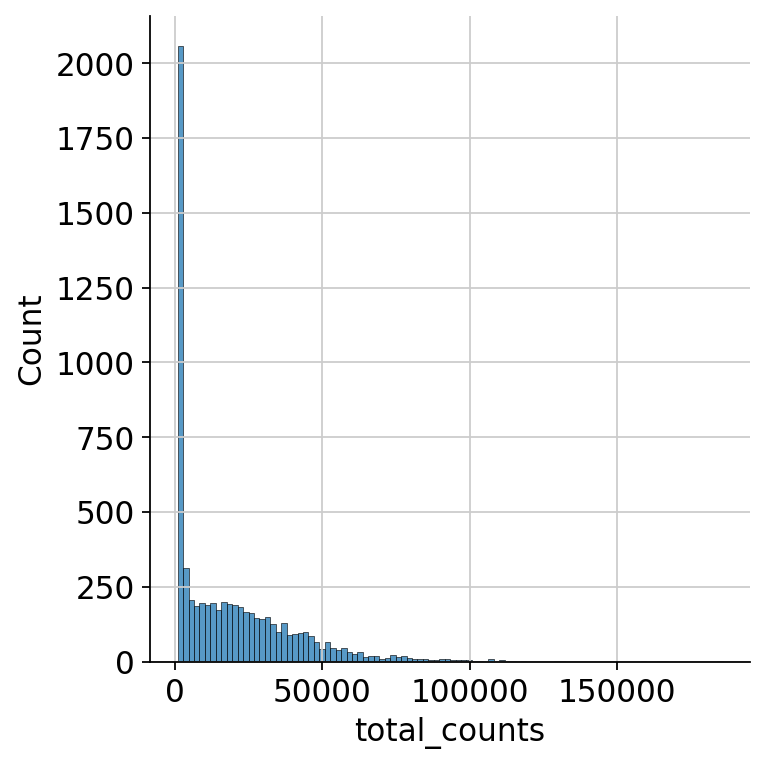

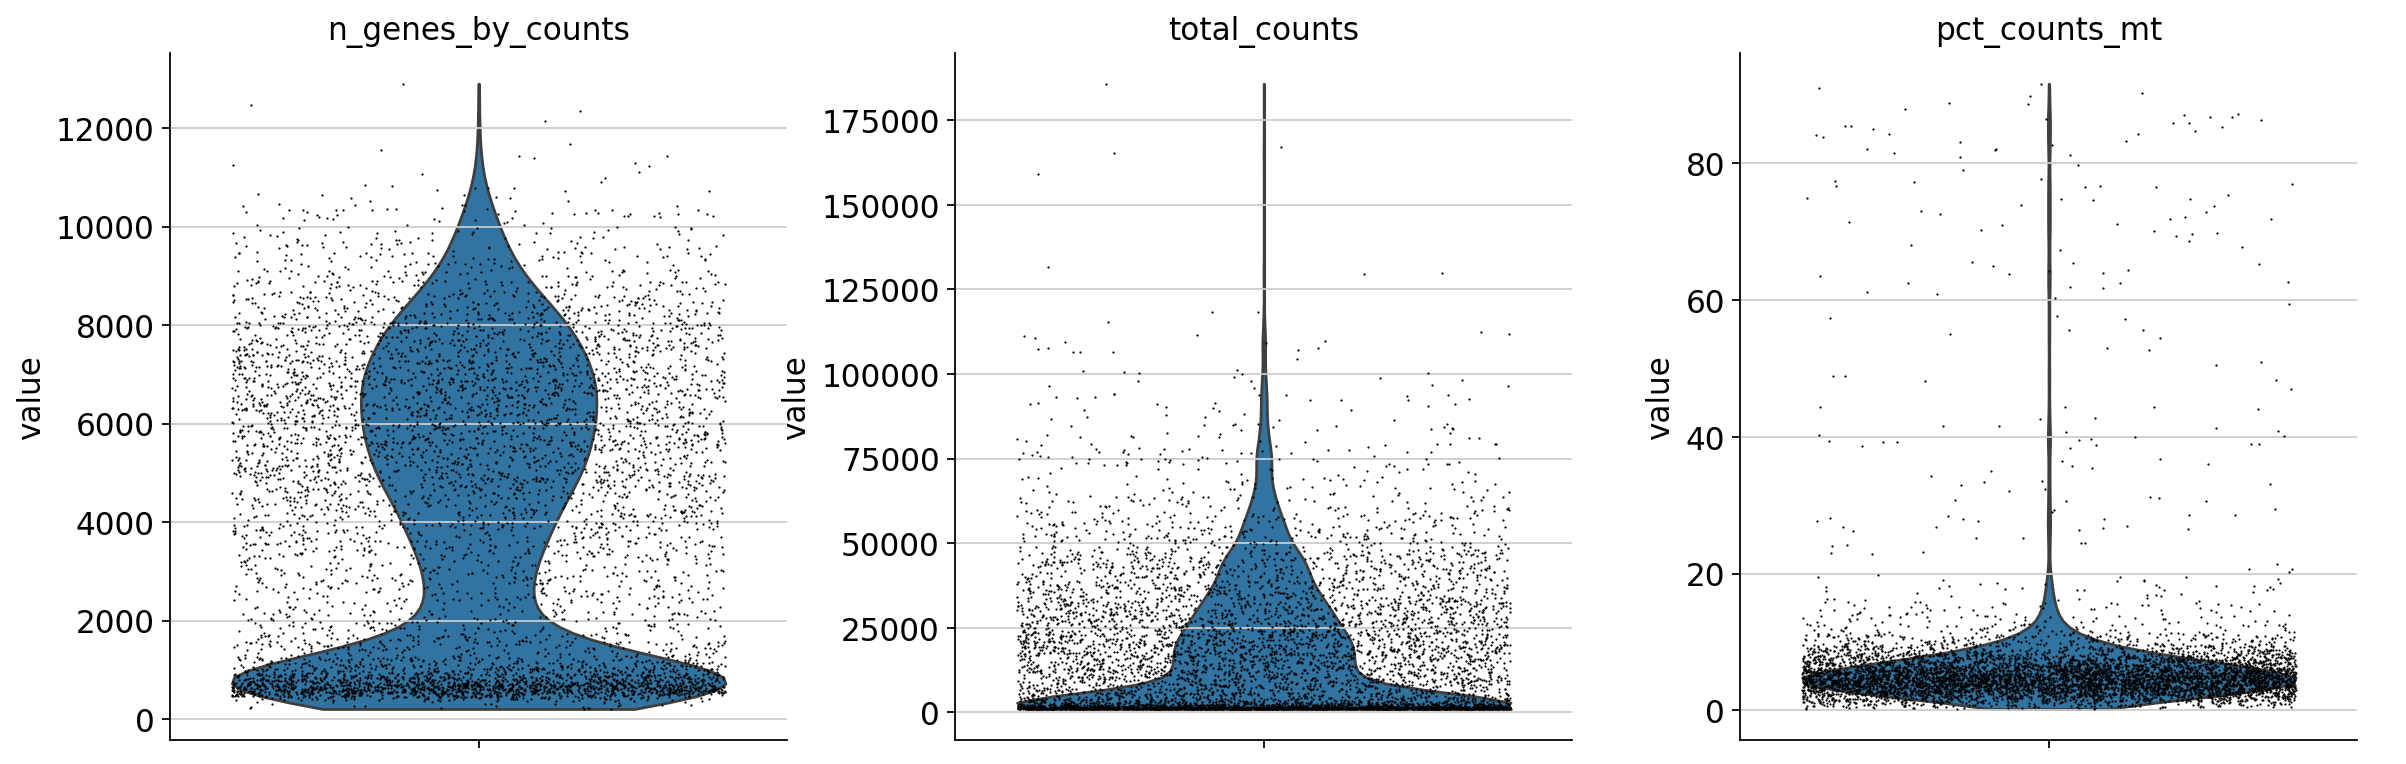

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


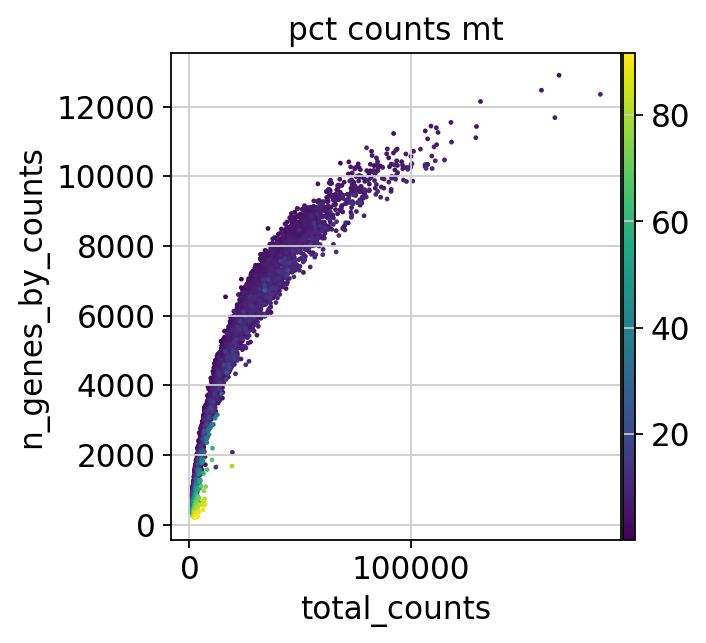

In [46]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [47]:
#Basic filtering:
adata = adata[adata.obs.n_genes_by_counts < 11000, :]
adata = adata[adata.obs.n_genes_by_counts > 1500, :]
#adata = adata[adata.obs.total_counts > 2000, :]

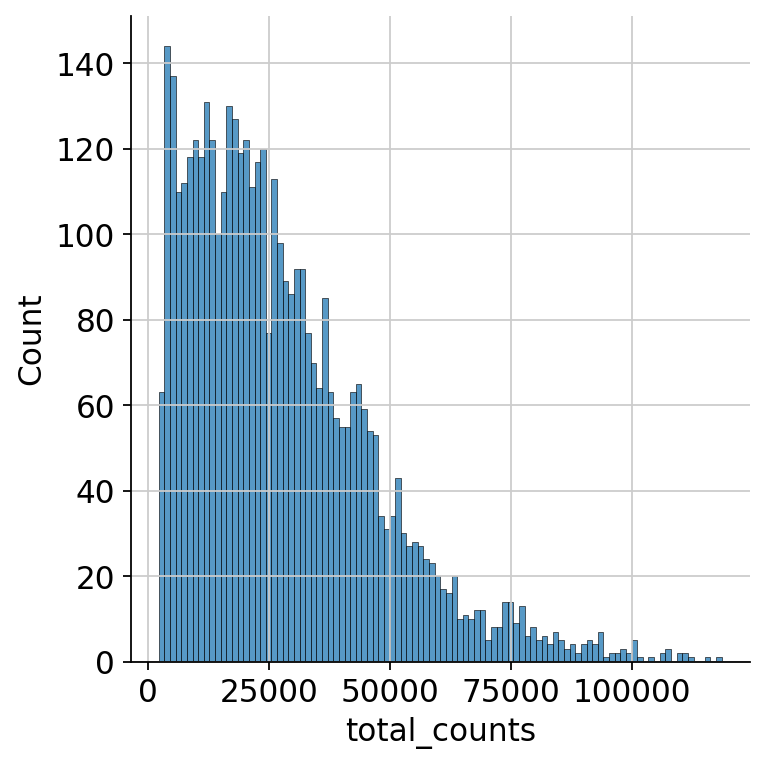

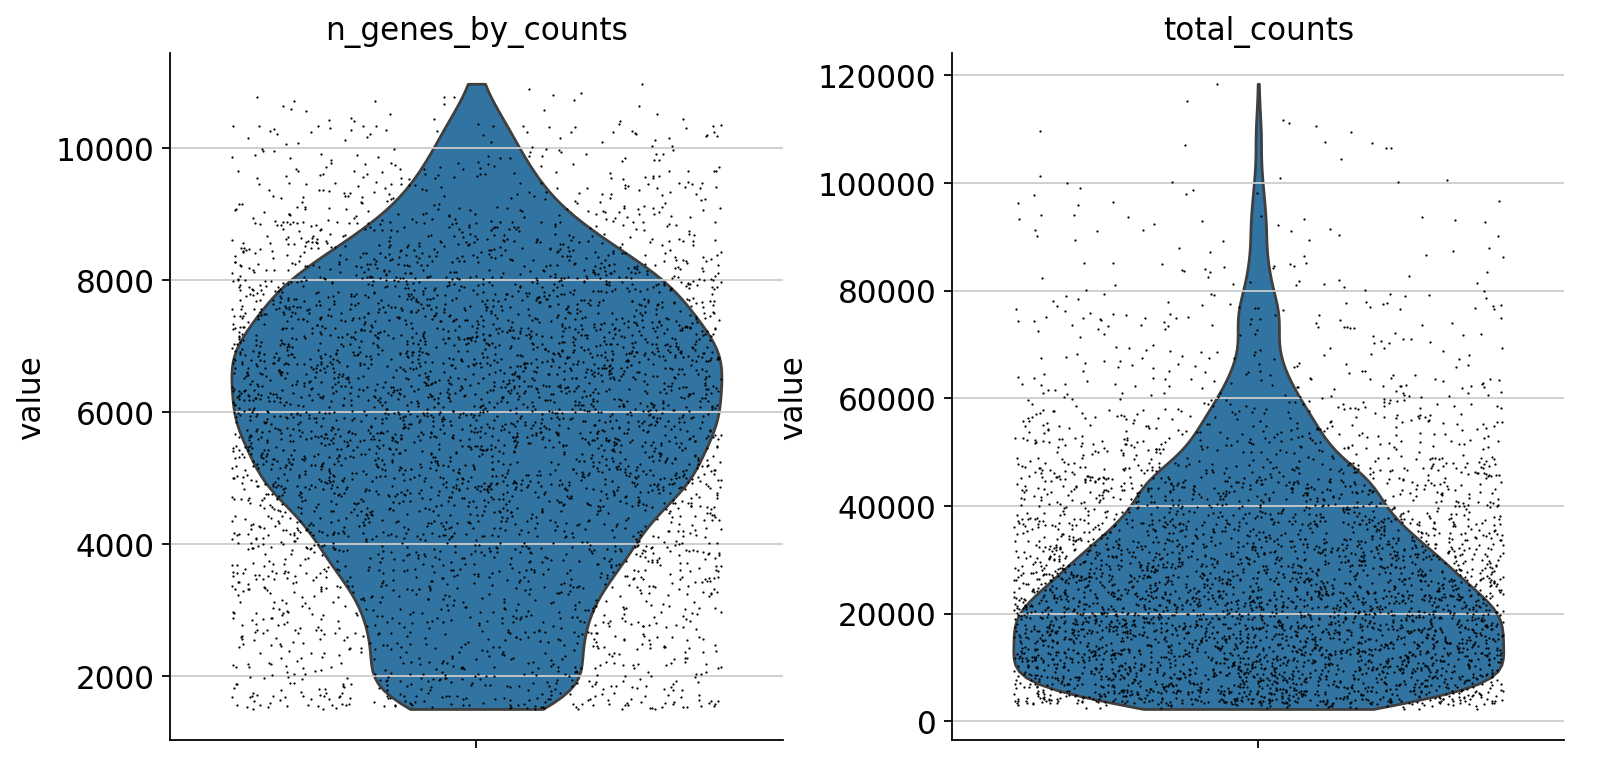

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


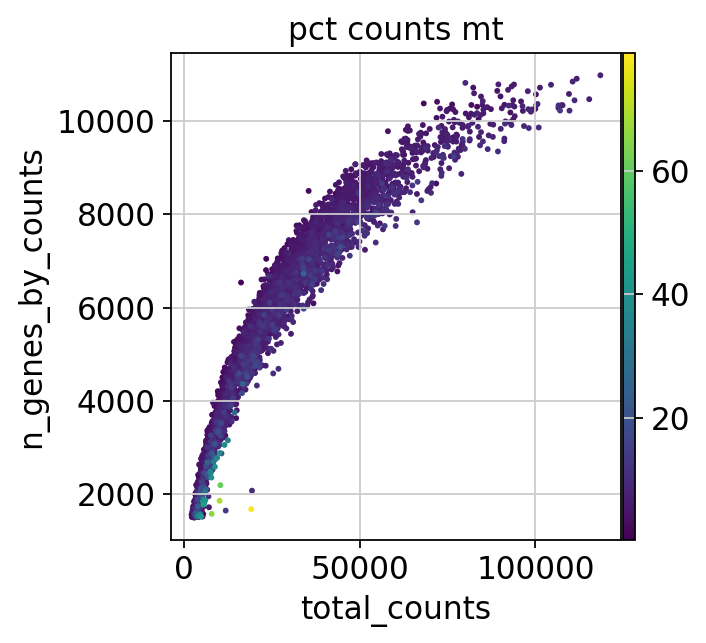

In [48]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [49]:
#filter
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

/tmp/ipykernel_433657/3121625339.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["outlier"] = (


outlier
False    4152
True      147
Name: count, dtype: int64

In [50]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    3568
True      731
Name: count, dtype: int64

In [51]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 4299
Number of cells after filtering of low quality cells: 3477


/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


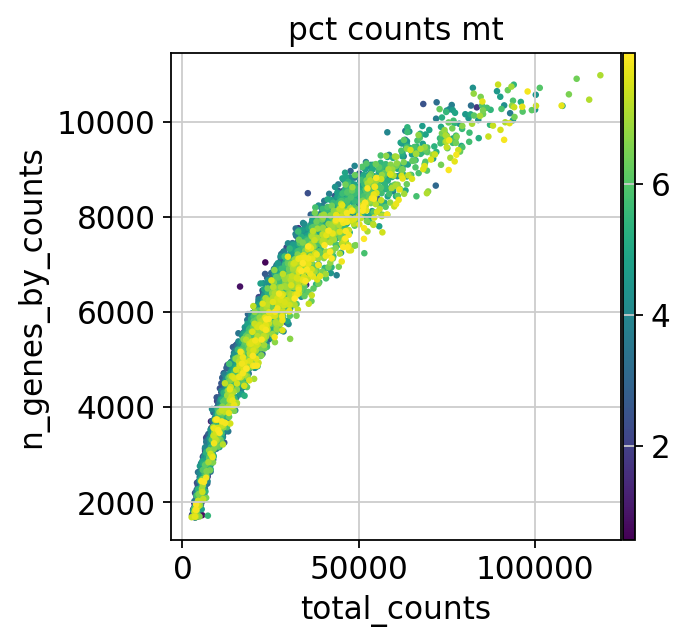

In [52]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Correction of ambient RNA

In [53]:
%%R
library(SoupX)

In [54]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [55]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [56]:
del adata_pp

In [57]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [58]:
data

<31766x3477 sparse matrix of type '<class 'numpy.float64'>'
	with 20525971 stored elements in Compressed Sparse Column format>

In [59]:
adata_raw = sc.read_h5ad(
    filename="/data/home/wx/scislets/data/CT/output/h5ad/raw.h5ad"
)
adata_raw.var_names_make_unique()
cells_raw = adata_raw.obs_names
genes_raw = adata_raw.var_names
data_tod = adata_raw.X.T


In [60]:
del adata_raw

In [61]:
%%R -i data -i data_tod -i genes -i cells  -i genes_raw -i cells_raw -i soupx_groups -o out

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
rownames(data_tod) = genes_raw
colnames(data_tod) = cells_raw
data_tod <- data_tod[rownames(data),]
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")
#data_tod <- subset(data_tod,rownames(data_tod) %in% rownames(data))
# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

813 genes passed tf-idf cut-off and 4 soup quantile filter.  Taking the top 4.
Using 25 independent estimates of rho.
Estimated global rho of 0.06
Expanding counts from 19 clusters to 3477 cells.
In addition: Warning messages:
1: In autoEstCont(sc, doPlot = FALSE) :
  Fewer than 10 marker genes found.  Is this channel low complexity (see help)?  If not, consider reducing tfidfMin or soupQuantile
2: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [62]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [63]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 31766
Number of genes after cell filter: 22190


(rna:doublet-detection)=
## Doublet Detection

In [64]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [65]:
data_mat = adata.X.T

In [66]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 297 cells excluded from training.
iter=1, 394 cells excluded from training.
iter=2, 424 cells excluded from training.
Threshold found:0.767
258 (7.4%) doublets called


In [67]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    3219
doublet     258
Name: count, dtype: int64

In [68]:
adata=adata[adata.obs.scDblFinder_class=="singlet", :]

In [69]:
adata.obs.scDblFinder_class

CELL17_N2       singlet
CELL22_N2       singlet
CELL28_N2       singlet
CELL32_N3       singlet
CELL36_N4       singlet
                 ...   
CELL97133_N1    singlet
CELL97152_N1    singlet
CELL97279_N1    singlet
CELL97344_N1    singlet
CELL97353_N1    singlet
Name: scDblFinder_class, Length: 3219, dtype: category
Categories (1, object): ['singlet']

In [70]:
adata.write("scislets/processed/CT_quality_control.h5ad")